### Check resources

In [1]:
! nvidia-smi

Sun Jul  3 20:19:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Mount drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My\ Drive/Licenta/Demo_Licenta
!ls

/content/drive/My Drive/Licenta/Demo_Licenta
 checkpoints  'Copy of cyclegan_resnet_gen.ipynb'


### Install required libraries

In [4]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


### Import libraries 

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
AUTOTUNE = tf.data.AUTOTUNE
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import numpy as np
import matplotlib.pyplot as plt

### Choose art style

In [6]:
#@title Choose art style

style = 'Monet' #@param ["Cezanne", "Monet", "Ukiyo-e", "VanGogh"]

if style == 'Cezanne':
    dataset_name = 'cezanne2photo'
elif style == 'Monet':
    dataset_name = 'monet2photo'
elif style == 'Ukiyo-e':
    dataset_name = 'ukiyoe2photo'
else:
    dataset_name = 'vangogh2photo'

### Load dataset

In [7]:
# load dataset from tensorflow datasets
dataset = tfds.load(f'cycle_gan/{dataset_name}', with_info = False, as_supervised = True)

# get the train art, train photo, test art, test photo subets from the loaded dataset
train_art, train_photo = dataset['trainA'], dataset['trainB']
test_art, test_photo = dataset['testA'], dataset['testB']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteDDQP1G/cycle_gan-trainA.tfrecord


  0%|          | 0/1072 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteDDQP1G/cycle_gan-trainB.tfrecord


  0%|          | 0/6287 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteDDQP1G/cycle_gan-testA.tfrecord


  0%|          | 0/121 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteDDQP1G/cycle_gan-testB.tfrecord


  0%|          | 0/751 [00:00<?, ? examples/s]

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0. Subsequent calls will reuse this data.


### Pre-process data

In [8]:
buffer_size = 256
batch_size = 1
img_size = [256, 256]

In [9]:
def resize(image, size = 286):
    return tf.image.resize(image, [size, size])

In [10]:
def augment(image):

    # random crop to 256 x 256 x 3
    image = tf.image.random_crop(image, size = [*img_size, 3])

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

In [11]:
# normalize pixel values to be in the [-1, 1] range
def normalize(image):
    return (tf.cast(image, tf.float32) / 127.5) - 1

In [12]:
# preprocess train dataset by augmenting and normalizing
def preprocess_train(image, label):
    image = resize(image)
    image = augment(image)
    image = normalize(image)
    return image

In [13]:
# preprocess test dataset by normalizing
def preprocess_test(image, label):
    image = normalize(image)
    return image

In [14]:
# augment and normalize train photo dataset 
train_photo = train_photo.cache().map(preprocess_train, num_parallel_calls=AUTOTUNE).shuffle(buffer_size).batch(batch_size)

# augment and normalize train art dataset
train_art = train_art.cache().map(preprocess_train, num_parallel_calls=AUTOTUNE).shuffle(buffer_size).batch(batch_size)

# normalize test photo dataset 
test_photo = test_photo.map(preprocess_test, num_parallel_calls=AUTOTUNE).cache().shuffle(buffer_size).batch(batch_size)

# normalize test art dataset 
test_art = test_art.map(preprocess_test, num_parallel_calls=AUTOTUNE).cache().shuffle(buffer_size).batch(batch_size)

(-0.5, 255.5, 255.5, -0.5)

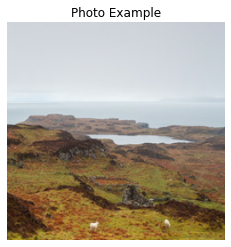

In [15]:
# take photo sample from train photo dataset
example_photo = next(iter(train_photo))

# plot photo sample
plt.imshow(example_photo[0] * 0.5 + 0.5); plt.title('Photo Example'); plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

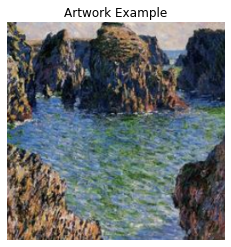

In [16]:
# take art sample from train art dataset
example_art = next(iter(train_art))

# plot art sample
plt.imshow(example_art[0] * 0.5 + 0.5); plt.title('Artwork Example'); plt.axis("off")

### Create model

In [17]:
class Padding2D(layers.Layer):
    def __init__(self, size, padding_mode = "REFLECT", **kwargs):
        self.size = size
        self.padding_mode = padding_mode
        super(Padding2D, self).__init__(**kwargs)

    def call(self, tensor, mask=None):
        return tf.pad(tensor = tensor, 
                      paddings = [[0, 0], [self.size, self.size], [self.size, self.size], [0, 0]], 
                      mode = self.padding_mode, 
                      constant_values=0)

In [18]:
# downsampling function (Conv2D -> Norm -> Leaky ReLU)
def downsampling_block(filters, 
                       norm_method = None,
                       activation = None,
                       kernel_size = 3, 
                       strides = 1, 
                       padding ='same', 
                       use_bias = False):

  # create sequential model
  result = keras.Sequential()

  # initializer for the kernel weights matrix
  kernel_initializer = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

  # add convolutional layer
  result.add(layers.Conv2D(filters = filters,
                           kernel_size = kernel_size, 
                           strides = strides, 
                           padding = padding,
                           use_bias = use_bias,
                           kernel_initializer = kernel_initializer))
  
  # initializer for instance normalization.
  gamma_initializer = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

  if norm_method:
    if norm_method == 'batch':
      # add batch normalization layer 
      result.add(layers.BatchNormalization())
    elif norm_method == 'instance':
      # add instance normalization layer 
      result.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma_initializer))

  if activation:
    # add activation function
    result.add(activation)

  return result

In [19]:
def residual_block(filters,
                   norm_method = None,
                   activation = None,
                   kernel_size = 3,
                   strides = 1,
                   padding = "valid",
                   use_bias = False):

    
  # create sequential model
  result = keras.Sequential()

  # add reflection padding
  result.add(Padding2D(size = 1, padding_mode = "REFLECT"))

  # initializer for the kernel weights matrix
  kernel_initializer = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

  # add convolutional layer
  result.add(layers.Conv2D(filters = filters,
                           kernel_size = kernel_size, 
                           strides = strides, 
                           padding = padding,
                           use_bias = use_bias,
                           kernel_initializer = kernel_initializer))
  
  # initializer for instance normalization.
  gamma_initializer = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

  if norm_method:
    if norm_method == 'batch':
      # add batch normalization layer 
      result.add(layers.BatchNormalization())
    elif norm_method == 'instance':
      # add instance normalization layer 
      result.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma_initializer))

  if activation:
    # add activation
    result.add(activation)

  # add reflection padding
  result.add(Padding2D(size = 1, padding_mode = "REFLECT"))

  # add convolutional layer
  result.add(layers.Conv2D(filters = filters,
                           kernel_size = kernel_size, 
                           strides = strides, 
                           padding = padding,
                           use_bias = use_bias,
                           kernel_initializer = kernel_initializer))

  if norm_method:
    if norm_method == 'batch':
      # add batch normalization layer 
      result.add(layers.BatchNormalization())
    elif norm_method == 'instance':
      # add instance normalization layer 
      result.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma_initializer))

  return result

In [20]:
# upsampling function (Conv2DTranspose -> Norm -> Dropout -> ReLU)
def upsampling_block(filters,
                     norm_method = None,
                     dropout_rate = None,
                     activation = None,
                     kernel_size = 3, 
                     strides = 1, 
                     padding ='same', 
                     use_bias = False):

  # create sequential model
  result = keras.Sequential()

  # initializer for the kernel weights 
  kernel_initializer = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

  # add convolutional layer
  result.add(layers.Conv2DTranspose(filters,
                                    kernel_size, 
                                    strides = strides, 
                                    padding = padding,
                                    use_bias = use_bias,
                                    kernel_initializer = kernel_initializer))
  
  # initializer for instance normalization.
  gamma_initializer = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

  if norm_method:
    if norm_method == 'batch':
      # add batch normalization layer 
      result.add(layers.BatchNormalization())
    elif norm_method == 'instance':
      # add instance normalization layer 
      result.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma_initializer))

  if dropout_rate:
    # add dropout layer
    result.add(layers.Dropout(rate = dropout_rate))

  if activation:
    # add activation function
    result.add(activation)

  return result

In [21]:
def generator(filters = 64,
              norm_method = None,
              downsample_no = 2,
              residual_no = 9,
              upsample_no = 2):
  
  # define input layer
  input = layers.Input(shape = (256, 256, 3)) # (None, 256, 256, 3)

  # add reflection padding
  x = Padding2D(size = 3, padding_mode = "REFLECT")(input) # (None, 262, 262, 3)

  # initializer for the kernel weights matrix
  kernel_initializer = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

  # add transpose convolution layer
  x = layers.Conv2D(filters = filters, 
                    kernel_size = 7, 
                    kernel_initializer = kernel_initializer, 
                    use_bias = False)(x) # (None, 256, 256, 64)

  # initializer for instance normalization.
  gamma_initializer = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

  if norm_method:
    if norm_method == 'batch':
      # add batch normalization layer 
      x = layers.BatchNormalization()(x)
    elif norm_method == 'instance':
      # add instance normalization layer 
      x = tfa.layers.InstanceNormalization(gamma_initializer = gamma_initializer)(x) # (None, 256, 256, 64)

  # add relu activation
  x = layers.Activation("relu")(x) # (None, 256, 256, 64)

  # add downsampling blocks
  for i in range(downsample_no): # (None, 128, 128, 128) -> (None, 64, 64, 256)
    filters *= 2
    x = downsampling_block(filters = filters,  
                           norm_method = 'instance',
                           activation = layers.Activation("relu"),
                           strides = 2)(x)

  # add residual blocks
  for i in range(residual_no): # (None, 64, 64, 256)
    dim = x.shape[-1]
    inp = x
    x = residual_block(filters = dim,
                       norm_method = 'instance',
                       activation = layers.Activation("relu"))(inp)
    x = layers.add([inp, x])

  filters = x.shape[-1]
  # add upsampling blocks
  for i in range(upsample_no): # (None, 128, 128, 128) -> (None, 256, 256, 64)
    filters //= 2
    x = upsampling_block(filters, 
                         norm_method = 'instance',
                         activation = layers.Activation("relu"),
                         strides = 2)(x)

  # add reflection padding
  x = Padding2D(size = 3, padding_mode = "REFLECT")(x) # (None, 262, 262, 64)

  # add convolutional layer
  x = layers.Conv2D(filters = 3, kernel_size = 7, padding = "valid")(x) # (None, 256, 256, 3)

  # add tanh activation
  output = layers.Activation("tanh")(x) # (None, 256, 256, 3)

  return keras.models.Model(inputs = input, outputs = output)

In [22]:
def discriminator(filters = 64, 
                  downsample_no = 3):
  
  input = layers.Input(shape = (256, 256, 3)) # (None, 256, 256, 3)

  kernel_initializer = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

  x = layers.Conv2D(filters = filters,
                    kernel_size = 4,
                    strides = 2,
                    padding = "same",
                    kernel_initializer = kernel_initializer)(input) # (None, 128, 128, 64)

  x = layers.LeakyReLU(alpha = 0.2)(x) #  (None, 128, 128, 64)

  x = downsampling_block(filters = filters * 2,
                         norm_method = 'instance',
                         activation = layers.LeakyReLU(alpha = 0.2),
                         kernel_size = 4,
                         strides = 2)(x) # (None, 64, 64, 128) 

  x = downsampling_block(filters = filters * 4,
                         norm_method = 'instance',
                         activation = layers.LeakyReLU(alpha = 0.2),
                         kernel_size = 4,
                         strides = 2)(x) # (None, 32, 32, 256)

  x = downsampling_block(filters = filters * 8,
                         norm_method = 'instance',
                         activation = layers.LeakyReLU(alpha = 0.2),
                         kernel_size = 4,
                         strides = 1)(x) # (None, 32, 32, 512) 

  output = layers.Conv2D(filters = 1, 
                         kernel_size = 4, 
                         strides = 1, 
                         padding = "same", 
                         kernel_initializer = kernel_initializer)(x) # (None, 32, 32, 1) 

  return keras.models.Model(inputs = input, outputs = output)

In [23]:
# CycleGAN art and photo generators - U-Net model with transformer

# art gen: photo -> art
art_gen = generator(norm_method = 'instance')
# photo gen: art -> photo
photo_gen = generator(norm_method = 'instance')


# CycleGAN art and photo discriminators - PatchGAN model

# art_disc: decides whether artwork is real or fake
art_disc = discriminator()
# photo_disc: decides whether photo is real or fake
photo_disc = discriminator()

In [24]:
# check discriminator model
art_disc.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_44 (Conv2D)          (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 sequential_26 (Sequential)  (None, 64, 64, 128)       131328    
                                                                 
 sequential_27 (Sequential)  (None, 32, 32, 256)       524800    
                                                                 
 sequential_28 (Sequential)  (None, 32, 32, 512)       2098176   
                                                                 
 conv2d_48 (Conv2D)          (None, 32, 32, 1)         8193

In [25]:
# check generator model
art_gen.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 padding2d (Padding2D)          (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  9408        ['padding2d[0][0]']              
                                )                                                                 
                                                                                              

In [26]:
class CycleGan(keras.Model):
    def __init__(self, 
                 art_gen, 
                 photo_gen, 
                 art_disc, 
                 photo_disc, 
                 alpha_cycle=10.0,
                 alpha_identity=0.5):

        super(CycleGan, self).__init__()
        self.art_gen = art_gen
        self.photo_gen = photo_gen
        self.art_disc = art_disc
        self.photo_disc = photo_disc
        self.alpha_cycle = alpha_cycle
        self.alpha_identity = alpha_identity

    # define optimizers and loss function
    def compile(self, 
                art_gen_opt, 
                photo_gen_opt, 
                art_disc_opt, 
                photo_disc_opt):

        super(CycleGan, self).compile()
        self.art_gen_opt = art_gen_opt
        self.photo_gen_opt = photo_gen_opt
        self.art_disc_opt = art_disc_opt
        self.photo_disc_opt = photo_disc_opt
        self.gen_loss_func = keras.losses.MeanSquaredError()
        self.disc_loss_func = keras.losses.MeanSquaredError()
        self.cycle_consistency_loss_func = keras.losses.MeanAbsoluteError()
        self.identity_loss_func = keras.losses.MeanAbsoluteError()

    # define what happens when we call model.fit
    def train_step(self, art_photo_zip):
        real_art, real_photo = art_photo_zip
        with tf.GradientTape(persistent=True) as tape:
            ### GENERATOR LOSS ###

            ## PHOTO CYCLE CONSISTENCY LOSS ##

            # generate fake art with art generator
            fake_art = self.art_gen(real_photo, training=True)
            # put generated art through photo generator to obtain cycled photo
            cycle_photo = self.photo_gen(fake_art, training=True)

            # compute photo cycle consistency loss
            photo_cycle_consistency_loss = self.alpha_cycle * self.cycle_consistency_loss_func(real_photo, cycle_photo)

            ## ART CYCLE CONSISTENCY LOSS ##

            # generate fake photo with photo generator
            fake_photo = self.photo_gen(real_art, training=True)
            # put generated photo through art generator to obtain the cycled art
            cycle_art = self.art_gen(fake_photo, training=True)

            # compute art cycle consistency loss
            art_cycle_consistency_loss = self.alpha_cycle * self.cycle_consistency_loss_func(real_art, cycle_art)


            ## PHOTO IDENTITY LOSS ##

            # put real photo through photo generator to obtain identity photo
            identity_photo = self.photo_gen(real_photo, training=True)
            # compute photo identity loss
            photo_identity_loss = self.alpha_identity * self.alpha_cycle * self.identity_loss_func(real_photo, identity_photo)

            ## ART IDENTITY LOSS ##

            # put real art through art generator to obtain identity art
            identity_art = self.art_gen(real_art, training=True)
            # compute art identity loss
            art_identity_loss = self.alpha_identity * self.alpha_cycle  * self.identity_loss_func(real_art, identity_art)

            ## PHOTO GENERATOR LOSS ##

            # get photo discriminator output on real photo
            real_photo_disc = self.photo_disc(real_photo, training=True)
            # get photo discriminator output on generated photo
            fake_photo_disc = self.photo_disc(fake_photo, training=True)

            # compute photo generator loss
            photo_gen_loss = self.gen_loss_func(tf.ones_like(fake_photo_disc), fake_photo_disc)

            ## ART GENERATOR LOSS ##

            # get art discriminator output on real art
            real_art_disc = self.art_disc(real_art, training=True)
            # get art discriminator output on generated art
            fake_art_disc = self.art_disc(fake_art, training=True)

            # compute art generator loss
            art_gen_loss = self.gen_loss_func(tf.ones_like(fake_art_disc), fake_art_disc)

            # compute total photo generator loss
            total_photo_gen_loss = photo_gen_loss + photo_cycle_consistency_loss + photo_identity_loss

            # compute total art generator loss
            total_art_gen_loss = art_gen_loss + art_cycle_consistency_loss + art_identity_loss

            ### DISCRIMINATOR LOSS ###

            # compute photo discriminator loss
            photo_disc_loss = (self.disc_loss_func(tf.ones_like(real_photo_disc), real_photo_disc) 
                             + self.disc_loss_func(tf.zeros_like(fake_photo_disc), fake_photo_disc)) * 1/2

            # compute art discriminator loss
            art_disc_loss = (self.disc_loss_func(tf.ones_like(real_art_disc), real_art_disc) 
                           + self.disc_loss_func(tf.zeros_like(fake_art_disc), fake_art_disc)) * 1/2

            ### GRADIENTS ###

            # compute photo generator gradients
            photo_gen_grads = tape.gradient(total_photo_gen_loss,
                                            self.photo_gen.trainable_variables)
            # compute art generator gradients
            art_gen_grads = tape.gradient(total_art_gen_loss,
                                          self.art_gen.trainable_variables)
            # compute photo discriminator gradients
            art_disc_grads = tape.gradient(art_disc_loss,
                                           self.art_disc.trainable_variables)
            # compute art discriminator gradients
            photo_disc_grads = tape.gradient(photo_disc_loss,
                                             self.photo_disc.trainable_variables)

            ### UPDATE VARIABLES ###

            # apply gradients to photo generator optimizer
            self.photo_gen_opt.apply_gradients(zip(photo_gen_grads,
                                                   self.photo_gen.trainable_variables))
            # apply gradients to art generator optimizer
            self.art_gen_opt.apply_gradients(zip(art_gen_grads,
                                            self.art_gen.trainable_variables))
            # apply gradients to photo discriminator optimizer
            self.photo_disc_opt.apply_gradients(zip(photo_disc_grads,
                                               self.photo_disc.trainable_variables))
            # apply gradients to art discriminator optimizer
            self.art_disc_opt.apply_gradients(zip(art_disc_grads,
                                             self.art_disc.trainable_variables))

        return {"art_gen_loss": total_art_gen_loss,
                "photo_gen_loss": total_photo_gen_loss,
                "art_disc_loss": art_disc_loss,
                "photo_disc_loss": photo_disc_loss}

### Check initial generator & discriminator performance

(-0.5, 255.5, 255.5, -0.5)

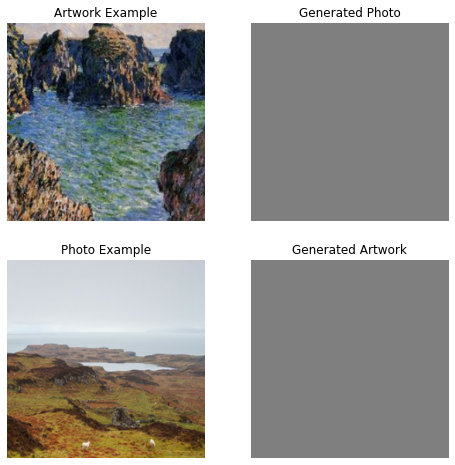

In [27]:
# generate artwork from example_photo
example_gen_art = art_gen(example_photo)
# generate photo from example_art
example_gen_photo = photo_gen(example_art)

# plot real artwork, generated photo, real photo & generated artwork
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1); 
plt.imshow((example_art[0].numpy() * 127.5 + 127.5).astype(np.uint8)); 
plt.title('Artwork Example'); 
plt.axis("off")

plt.subplot(2, 2, 2); 
plt.imshow((example_gen_photo[0].numpy() * 127.5 + 127.5).astype(np.uint8)); 
plt.title('Generated Photo'); 
plt.axis("off")

plt.subplot(2, 2, 3); 
plt.imshow((example_photo[0].numpy() * 127.5 + 127.5).astype(np.uint8)); 
plt.title('Photo Example'); 
plt.axis("off")

plt.subplot(2, 2, 4); 
plt.imshow((example_gen_art[0].numpy() * 127.5 + 127.5).astype(np.uint8)); 
plt.title('Generated Artwork'); 
plt.axis("off")

(-0.5, 31.5, 31.5, -0.5)

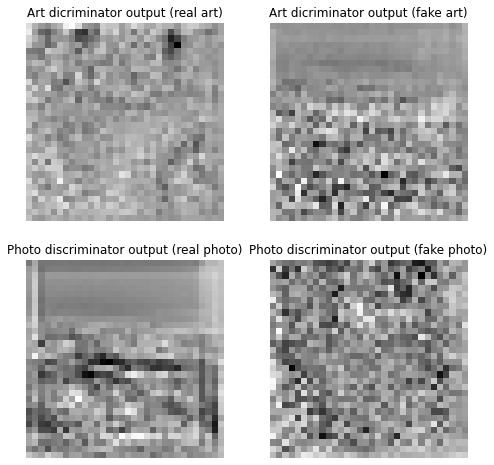

In [28]:
plt.figure(figsize=(8, 8))

plt.subplot(221); 
plt.imshow(art_disc(example_art)[0, ..., -1], cmap='gray')
plt.axis("off")
plt.title('Art dicriminator output (real art)')

plt.subplot(222); 
plt.imshow(art_disc(example_gen_art)[0, ..., -1], cmap='gray')
plt.axis("off")
plt.title('Art dicriminator output (fake art)')


plt.subplot(223)
plt.imshow(photo_disc(example_photo)[0, ..., -1], cmap='gray')
plt.title('Photo discriminator output (real photo)')
plt.axis("off")

plt.subplot(224)
plt.imshow(photo_disc(example_gen_photo)[0, ..., -1], cmap='gray')
plt.title('Photo discriminator output (fake photo)')
plt.axis("off")

### Initialize optimizers

In [29]:
art_gen_opt = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.999, epsilon=1e-07)
photo_gen_opt = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.999, epsilon=1e-07)

art_disc_opt = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.999, epsilon=1e-07)
photo_disc_opt = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.999, epsilon=1e-07)

### Compile model

In [30]:
cycle_gan = CycleGan(art_gen=art_gen, 
                     photo_gen=photo_gen, 
                     art_disc=art_disc, 
                     photo_disc=photo_disc)

cycle_gan.compile(art_gen_opt = art_gen_opt,
                  photo_gen_opt = photo_gen_opt,
                  art_disc_opt = art_disc_opt,
                  photo_disc_opt = photo_disc_opt)

### Save checkpoints callback

In [31]:
checkpoint_path = f"./checkpoints/{style.lower()}_checkpoint/"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose = 1, 
    save_freq = 'epoch', 
    period = 5)

try:
  cycle_gan.load_weights(checkpoint_path)
except Exception as e:
        print(e)
else:
        print('Latest checkpoint restored!')

Latest checkpoint restored!


### Plot generator outputs callback

In [32]:
# function to plot initial image and generator output image side by side
def generator_output(generator, image):

  # generate image from input image
  generated_image = generator(image)
    
  # plot the input image and the generated image side by side
  plt.figure(figsize=(12, 12))
  plt.subplot(121); 
  plt.title('Input image'); 
  plt.imshow((image[0].numpy() * 127.5 + 127.5).astype(np.uint8)); 
  plt.axis('off')

  plt.subplot(122); 
  plt.title('Generated image'); 
  plt.imshow((generated_image[0].numpy() * 127.5 + 127.5).astype(np.uint8)); 
  plt.axis('off')
  plt.show()

In [33]:
# callback to plot initial image and generator output image side by side every epoch
class GeneratorOutputCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        generator_output(art_gen, example_photo)

In [34]:
generator_output_callback = GeneratorOutputCallback()

### Show and save results

In [36]:
# Show generator output on 10 random examples
for sample_photo in test_photo.take(10):
    generator_output(art_gen, sample_photo)

Output hidden; open in https://colab.research.google.com to view.